In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance
import mplfinance as mplf

from sklearn.cluster import KMeans

In [2]:
def get_trading_pair(name="BTC-USD", period="5d", interval="30m"):
    # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
    # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
    btc = yfinance.Ticker(name)
    hist = btc.history(period=period, interval=interval)
    return hist

In [378]:

class KmeansSupportResistance:
    
    def __init__(self, df: pd.DataFrame, saturation_point=0.5):
        self.optimum = None

        self.wcss = []
        self.clusters = []
        self.levels = []
        
        self.df = df
        self.saturation_point = saturation_point
        
        self.__compute_kmeans_wcss()
        self.__retrieve_centroids()
        
    def __compute_kmeans_wcss(self):
        '''
        :param df: dataframe
        :param saturation_point: The amount of difference we are willing to detect
        :return: clusters with optimum K centers
        
        This method uses elbow method to find the optimum number of K clusters
        We initialize different K-means with 1..10 centers and compare the inertias
        If the difference is no more than saturation_point, we choose that as K and move on
        '''

        size = min(11, len(self.df.index))
        for i in range(1, size):
            kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
            kmeans.fit(self.df)
            
            self.wcss.append(kmeans.inertia_)
            self.clusters.append(kmeans)

        # Compare differences in inertias until it's no more than saturation_point
        optimum_k = len(self.wcss)-1
        for i in range(0, len(self.wcss)-1):
            delta = self.wcss[i+1] / self.wcss[i]

            if delta > self.saturation_point:
                optimum_k = i + 1
                break

        print("Optimum K is " + str(optimum_k + 1))
        self.optimum = self.clusters[optimum_k]

    def __retrieve_centroids(self):
        """ i.e. support and resistance levels. """
        self.levels = self.optimum.cluster_centers_
        self.levels = np.sort(self.levels, axis=0).reshape(-1)

    def get_n_clusters(self, n):
        kmeans = KMeans(n_clusters=n, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        return kmeans
    
    def plot_(self, data, variations: []=None, titles: []=None, labels: bool=False, figratio=(16,9), **kwargs):
        
        if not variations:
            variations = [self.levels]
            
        if titles and len(titles) != len(variations):
            raise Exception("Titles and args should have same shape, debug input")
        
        custom_style = mplf.make_mpf_style(base_mpf_style='charles', rc={
            "axes.labelcolor": "none",
            "axes.spines.bottom": False,
            "axes.spines.left": False,
            "axes.spines.right": False,
            "axes.spines.top": False,
            "font.size": 0,
            "xtick.color": "none",
            "ytick.color": "none",
        })


        fig = mplf.figure(style="charles", figsize=figratio)
        fig.suptitle(kwargs.get("main_title", ""))
        
        fig.subplots_adjust(kwargs.get('wspace', 0.1))
        fig.subplots_adjust(kwargs.get('hspace', 0.1))
        
        # subplot that takes  x y n, where n is the position
        # and x and y are proportions given to each plot from total space
        x = len(variations) // 2 + 1 
        y = 2 if len(variations) > 1 else 1
        lw = 2 if len(variations) == 1 else 1
        
        for n, levels in enumerate(variations):
            ax = fig.add_subplot(x,y,n+1)
            
            # if titles are not given, then plots will have empty titles
            title = titles[n] if titles else ''

            mplf.plot(data, 
                      type='candle', ax=ax, axtitle=title, 
                      hlines=dict(
                          hlines=[*levels],
                          linestyle='dotted',
                          linewidths=(lw), 
                          colors='black'), 
                      savefig='test-mplfiance.png'
                     )
            
            # Get rid of x and y labels
            if not labels:
                ax.set_xticklabels([])
                ax.set_yticklabels([])

    def plot_elbow():
        plt.plot(self.wcss, 'bx-')
        plt.xlabel('Values of K')
        plt.ylabel('Inertia')
        plt.title('The Elbow Method using Inertia')
        plt.show()

In [381]:
def get_(name, period, interval, n=None, **kwargs):
    # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
    # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
    data = get_trading_pair(name=name, period=period, interval=interval)
    
    data = data.drop(columns=['Volume', 'Dividends', 'Stock Splits'])

    lows = pd.DataFrame(data=data, index=data.index, columns=["Low"])
    highs = pd.DataFrame(data=data, index=data.index, columns=["High"])
    
    saturation_point = kwargs.get('saturation_point', 0.5)
    
    lowc = KmeansSupportResistance(lows, saturation_point)
    highc = KmeansSupportResistance(highs, saturation_point)

    lowc.plot_(data, 
               variations=[lowc.levels, highc.levels], 
               titles=["Kmeans on Lows", "Kmeans on Highs"], 
               main_title = f"{name}, period: {period}, interval: {interval}. Saturation {lowc.saturation_point}",
               **kwargs)

Optimum K is 7
Optimum K is 10
Optimum K is 6
Optimum K is 7
Optimum K is 6
Optimum K is 5
Optimum K is 3
Optimum K is 3


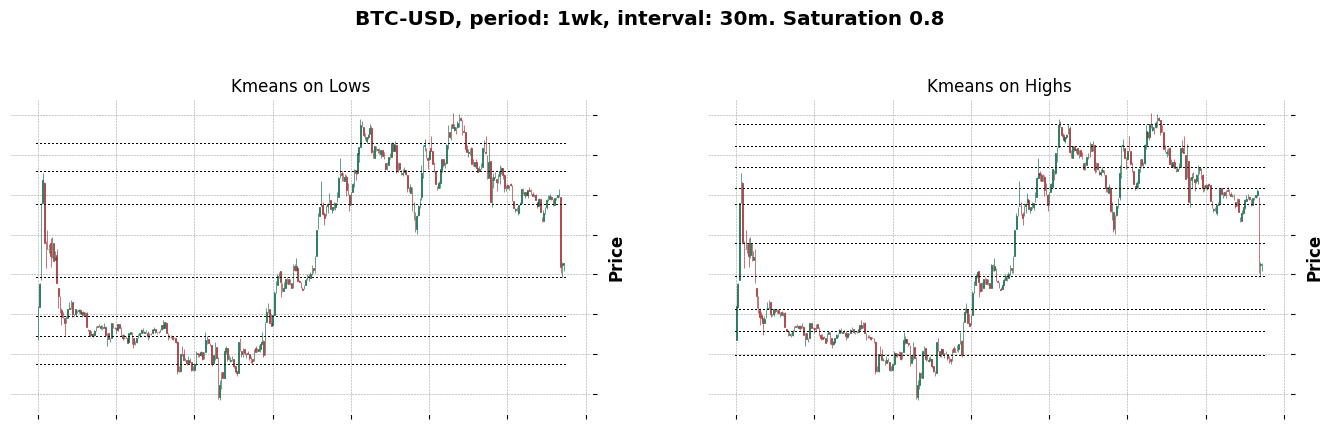

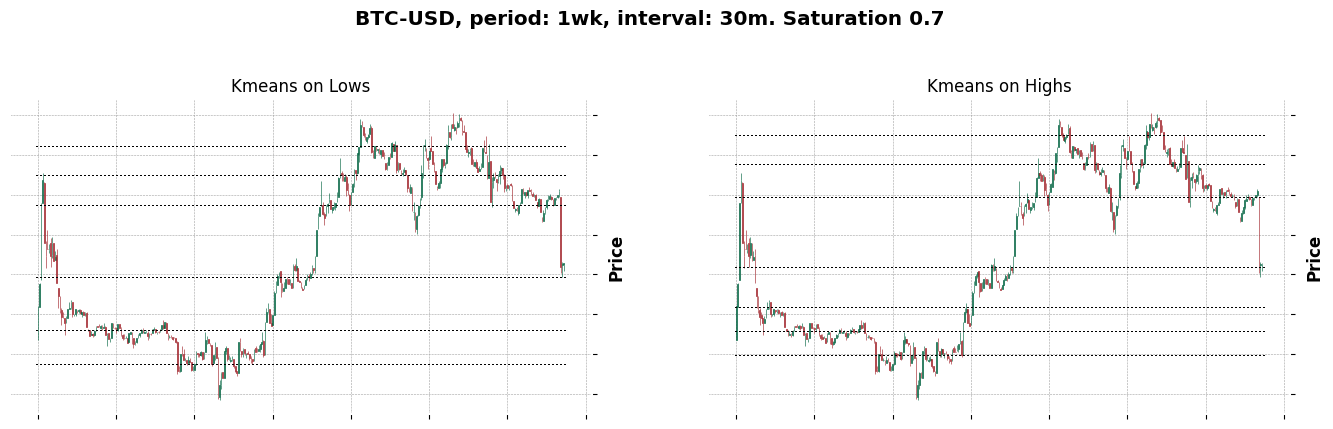

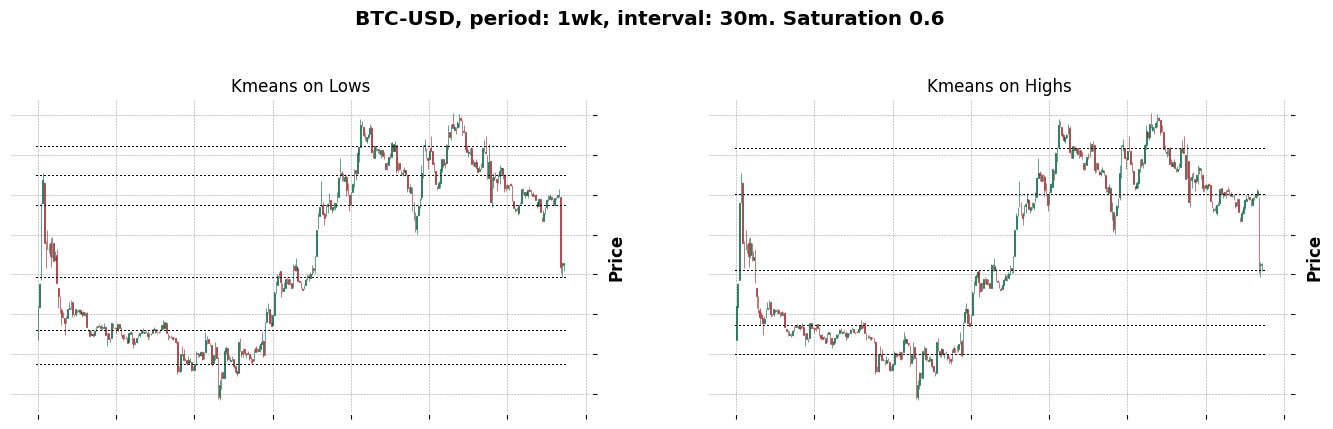

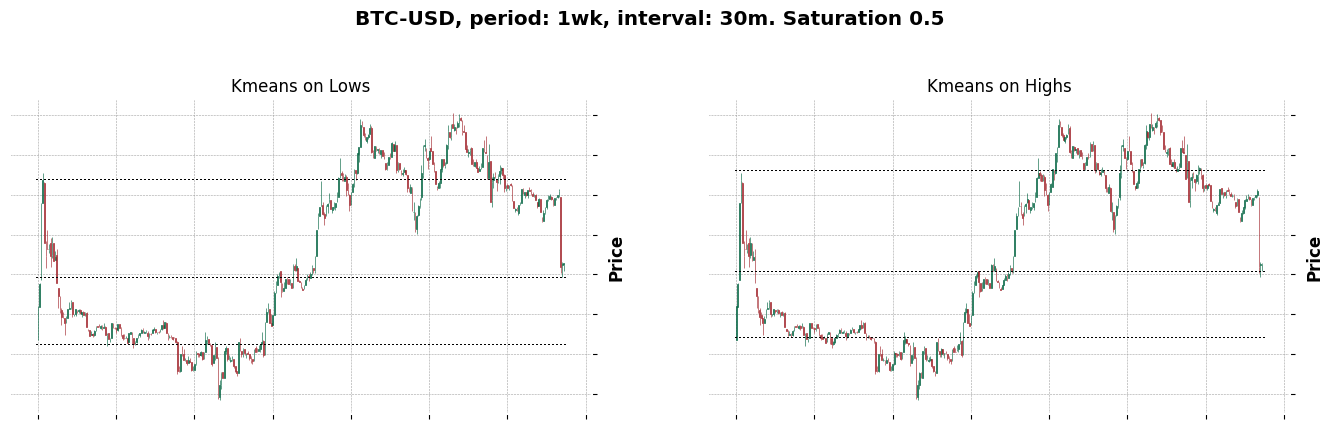

In [383]:
get_("BTC-USD", "1wk", "30m", saturation_point=0.8)
get_("BTC-USD", "1wk", "30m", saturation_point=0.7)
get_("BTC-USD", "1wk", "30m", saturation_point=0.6)
get_("BTC-USD", "1wk", "30m", saturation_point=0.5)